# Test outside models
Google Colab is great for training models, but not for testing them. Here we load the model outputs of colab-trained models and test them out!
This notebook is a tool to test how effective the model is getting at predicting specific aspects of these stars. We test on an HR diagram and against part of the Orion Molecular Cloud Complex

In [1]:
import pandas as pd

import sys
# print(sys.version)
import numpy as np

import torch
from torch import Tensor
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import matplotlib
from matplotlib import colors
matplotlib.style.use('science')
# print('PyTorch version:', torch.__version__)

import warnings
with warnings.catch_warnings():
    import imf,isochrones
    from isochrones.parsec import Parsec_Isochrone
    from isochrones.mist import MIST_Isochrone
    mist = MIST_Isochrone()
    pars = Parsec_Isochrone()
    
import pickle,time,random
from astropy.io import fits
from astropy.table import Table
from astropy.table import vstack
import astropy.units as u

# import psutil
# import humanize
# import os

params = {
    'axes.titlesize' : 24,
    'axes.labelsize' : 20,
    #lines.linewidth : 3,
    #lines.markersize : 10,
    'xtick.labelsize' : 16,
    'ytick.labelsize' : 16,
}
matplotlib.rcParams.update(params)

In [2]:
def convunit(v,b,back=False):
    a=[['g',21,0.5],['bp',21,0.5],['rp',18,0.5],['j',17.5,0.5],['h',16.5,0.5],['k',16.5,0.5],
         ['w1',16.5,0.5],['w2',16.5,0.5],['w3',14,0.5],['parallax',20,0.5],['radius',5,0.54],
         ['logl',4,0],['av',20,0.3],['age',4,2],['mass',3,0.5],['teff',0.7,3.4/0.7+0.5],
         ['logg',2,2],['feh',3,-2.5/3+0.5]]
    for i in a:
        if b==i[0]:
            if back:
                return (v+i[2])*i[1]
            else:
                return (v/i[1])-i[2] 

In [3]:
class Net(nn.Module):
    def __init__(self, input_shape = (1, 12), output_shape = 6):
        super(Net, self).__init__()
        self.conv1 = nn.Conv1d(1, 8, 3, padding = 1)
        self.conv2 = nn.Conv1d(8, 16, 3, padding = 1)
        self.conv3 = nn.Conv1d(16, 32, 3, padding = 1)
        n_size = self._get_conv_output(input_shape)
#         print(n_size)
        
        self.fc1 = nn.Linear(n_size, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, output_shape)      
        
    def _get_conv_output(self, shape):
        bs = 1
        input = (torch.rand(bs, *shape))
        output_feat = self._forward_features(input)
        n_size = output_feat.data.view(bs, -1).size(1)
        return n_size
    
    def _forward_features(self, x):
        x = F.max_pool1d(F.relu(self.conv2(F.relu(self.conv1(x)))),2)
        x = F.relu(F.max_pool1d(self.conv3(x), 2))
        return x
    
    def forward(self, x):
        x = self._forward_features(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        #x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
BAD_LOSS = 100000000
# model = Net()

# device = torch.device('cuda')

best_loss = BAD_LOSS
running_dev_loss = 0
badcount = 0
t = time.time()
n=0

a=torch.rand(23500,1,12)
criterion = nn.MSELoss(reduction='sum')
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-5, momentum=0.9)

In [4]:
device = torch.device('cuda')
model = Net(input_shape = (1,11), output_shape = 2)
model.load_state_dict(torch.load('Jul19AugBenchmark.pt'))

model1 = Net(input_shape = (1,11), output_shape = 2)
# model1.to(device)
model1.load_state_dict(torch.load('Jul23MaybeBenchmark.pt'))

model2 = Net(input_shape = (1,11), output_shape = 2)
model2.load_state_dict(torch.load('aModel.pt'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

So far, the best model is `model.load_state_dict(torch.load('Jul15NEWBenchmark.pt'))` or `Jul19AugBenchmark.pt`

In [5]:
def unpackFits(DATA,name):
    g = DATA['phot_g_mean_mag'].astype(np.float32)
    x=np.where((g<19) & (np.nan_to_num(g)>0))[0]
    g=g[x].to_numpy()
    bp = DATA['phot_bp_mean_mag'][x].astype(np.float32).to_numpy()
    rp = DATA['phot_rp_mean_mag'][x].astype(np.float32).to_numpy()
    j = DATA['j_m'][x].astype(np.float32).to_numpy()
    h = DATA['h_m'][x].astype(np.float32).to_numpy()
    if (name == 'orionTens') :
        k = DATA['k_m'][x].astype(np.float32).to_numpy()
    else:
        k=DATA['ks_m'][x].astype(np.float32).to_numpy()
    w1 = DATA['w1mpro'][x].astype(np.float32).to_numpy()
    w2 = DATA['w2mpro'][x].astype(np.float32).to_numpy()
#     w3 = DATA['W3MPRO'][x].astype(np.float32).to_numpy() #ignore for the most part
    parallax = DATA['parallax'][x].astype(np.float32).to_numpy()
    logl = np.log10(DATA['lum_val'][x].astype(np.float32).to_numpy())
    radius = DATA['radius_val'][x].astype(np.float32).to_numpy()

    np.warnings.filterwarnings('ignore')
    bp[np.where((bp>20.5)|(np.isnan(bp)))[0]]=21
    rp[np.where((rp>17.5)|(np.isnan(rp)))[0]]=18
    j[np.where((j>17)|(np.isnan(j)))[0]]=17.5
    h[np.where((h>16)|(np.isnan(h)))[0]]=16.5
    k[np.where((k>16)|(np.isnan(k)))[0]]=16.5
    w1[np.where((w1>16)|(np.isnan(w1)))[0]]=16.5
    w2[np.where((w2>16)|(np.isnan(w2)))[0]]=16.5
#     w3[np.where((w3>13.5)|(np.isnan(w3)))[0]]=14
    radius[np.where((radius<0.5)|(np.isnan(radius)))[0]]=0.5
    logl[np.where((logl<-1.54)|(np.isnan(logl)))[0]]=-1.54

    dataTens = Tensor(len(g), 1, 11)*0-0.5

    dataTens[:,0,0]= Tensor(convunit(g, 'g'))
    dataTens[:,0,1]= Tensor(convunit(bp, 'bp'))
    dataTens[:,0,2]= Tensor(convunit(rp, 'rp'))
    dataTens[:,0,3]= Tensor(convunit(j, 'j'))
    dataTens[:,0,4]= Tensor(convunit(h, 'h'))
    dataTens[:,0,5]= Tensor(convunit(k, 'k'))
    dataTens[:,0,6]= Tensor(convunit(w1, 'w1'))
    dataTens[:,0,7]= Tensor(convunit(w2, 'w2'))
#     dataTens[:,0,8]= Tensor(convunit(w3[c], 'w3'))
    dataTens[:,0,8]= Tensor(convunit(parallax, 'parallax'))
    dataTens[:,0,9]= Tensor(convunit(logl, 'logl'))
    dataTens[:,0,10]= Tensor(convunit(radius, 'radius'))
    pickle.dump(dataTens, open(name + '.pickle', 'wb'))
    
ori = pd.DataFrame(fits.open('largeOriSample.fits')[1].data)
gplane = pd.DataFrame(fits.open('GalPlane.fits')[1].data)
hlat = pd.DataFrame(fits.open('HighGal.fits')[1].data)

allSky = pd.DataFrame(fits.open('fullsky.fits')[1].data)

names = ['orionTens', 'gplaneTens', 'hilatTens']
for i in range(3):
    unpackFits([ori,gplane,hlat][i], names[i])

# unpackFits(ori, 'orionTens')
unpackFits(allSky, 'allSkyTens')

big = pd.DataFrame(fits.open('LongTable.fits')[1].data)
unpackFits(big, 'bigSkyTens')

In [6]:
#bad coding!
def tabINDS(tab):
    return tab[np.where((tab['phot_g_mean_mag']<19) & (np.nan_to_num(tab['phot_g_mean_mag'])>0))[0]]

oriTab = tabINDS(fits.open('largeOriSample.fits')[1].data)
galTab = tabINDS(fits.open('GalPlane.fits')[1].data)
hiTab = tabINDS(fits.open('HighGal.fits')[1].data)


allTab = tabINDS(fits.open('fullsky.fits')[1].data)

bigTab = tabINDS(fits.open('LongTable.fits')[1].data)

In [7]:
def reduceTestData(fname, remove_x = None, to_gpu = True): #Make sure things are put into files in this order!
    xpars =['g','bp','rp','j','h','k','w1','w2','parallax','radius','logl']
    
    a = np.where(np.isin(xpars, remove_x)==False)[0] #Finds indices that remove input remove_
    
    X = pickle.load(open(fname, 'rb'))
    X = X[:,:,a]
    if to_gpu == True:
        X = X.to(device)
    return (X)

ORI = reduceTestData('orionTens.pickle',to_gpu=False)
GAL = reduceTestData('gplaneTens.pickle', to_gpu = False)
HI = reduceTestData('hilatTens.pickle', to_gpu = False)

ALL = reduceTestData('allSkyTens.pickle', to_gpu = False)

BIG = reduceTestData('bigSkyTens.pickle', to_gpu = False)

def absG(g, prlx):
    return np.array(g +5 - 5 * np.log10(1000/prlx))

In [8]:
from functools import reduce #NOTE: PREVIOUS FUNCTION CALLED REDUCE
def bData(tab):#use params to find bad data
    p1 = np.where((tab['parallax_error']<.1)|(tab['parallax_error']/tab['parallax']<.1))[0]
    p2 = np.where(1.0857/tab['phot_g_mean_flux_over_error']<.03)[0]
    p3 = np.where(tab['astrometric_sigma5d_max']<.3)[0]
    p4 = np.where(tab['visibility_periods_used']< 8)[0]
    p5 = np.where((tab['astrometric_excess_noise']<1)|
                  ((tab['astrometric_excess_noise']>1)&(tab['astrometric_excess_noise_sig']<2)))[0]
    return reduce(np.intersect1d, (p1,p2,p3, p5))

In [9]:
def hr(inTens,inTab, maxAge, bad, save=False, out = True, mod = model):
    
    
    mod.eval()
    d = mod(inTens)
    dat = pd.DataFrame(d.cpu().detach().numpy(), columns = ['age', 'av']) #['age', 'av', 'mass', 'teff', 'logg', 'feh']
    base = pd.DataFrame(inTens.flatten(1).cpu().numpy(), columns = ['g','bp','rp','j','h','k','w1','w2','parallax','radius','logl'])


    for label, content in dat.items():
        dat[label] = convunit(content, label, back=True)#Return to typical form

    bprp = convunit(base['bp'], 'bp', back = True)-convunit(base['rp'], 'rp', back = True)
    G = absG(convunit(base['g'], 'g', back = True), convunit(base['parallax'], 'parallax', back = True))

    fig, ax = plt.subplots(1,1,figsize = (12,10))
    
    #Check for good quality data!
    if bad == False:
        d = bData(inTab)
    else:
        d = np.arange(len(inTab))

    age = np.array(dat['age'])
    ii = np.where(age<maxAge)[0]
    ii = np.intersect1d(d,ii)

    NORM = colors.Normalize(vmin = 5.5, vmax = 10)

    ax.set_ylim(14,-3.5)
    ax.set_xlim(-1,6)
    ax.set_xlabel('BP-RP')
    ax.set_ylabel('AbsG')

    a = ax.scatter(bprp[ii], G[ii], s = .1, c = age[ii],alpha = 1, norm = NORM, cmap = 'viridis')
    fig.colorbar(a, ax = ax, label = 'Age')
    ax.plot(np.linspace(0,4),2.8 * np.linspace(0,4)+2.16)
    plt.show()
    
    K = Table(inTab)
    K['age_predicted']=age
    if save == True:
        K[ii].write('drive/My Drive/YSO_ML/CHECKOUT_0.fits',overwrite=True)
    if out == True:
        return(K[ii])

In [11]:
print(len(ORI))
print(len(ALL))

718885
761272


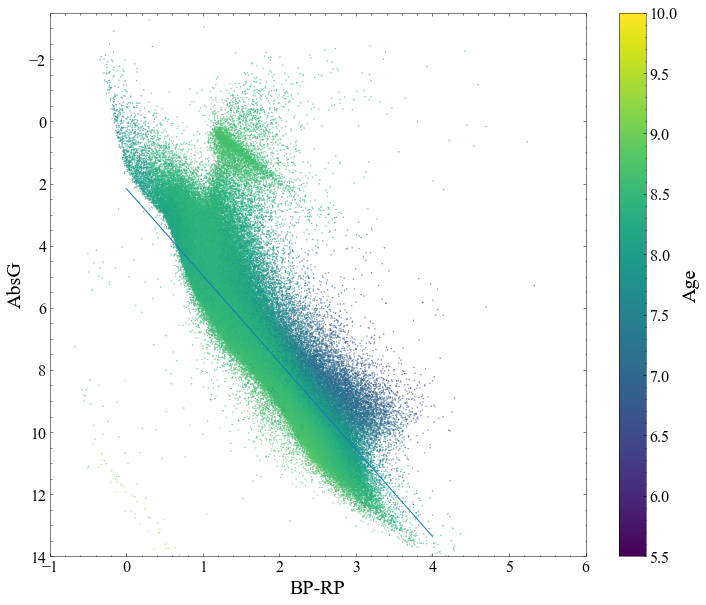

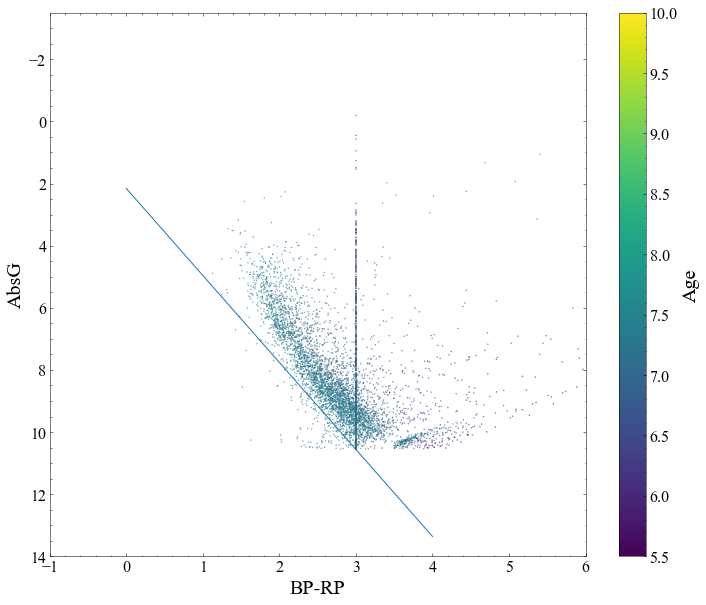

In [13]:
tOri = hr(ORI, oriTab,10.5,False, out = True)
# tPlane = hr(GAL, galTab,10.5,False, out = True)
# tHi = hr(HI[np.where(hiTab['PHOT_BP_MEAN_MAG']<21)[0],:,:], hiTab[np.where(hiTab['PHOT_BP_MEAN_MAG']<21)[0]], 10.5, False, out = True)
tAllSky = hr(ALL, allTab, 7.5, True, out= True)

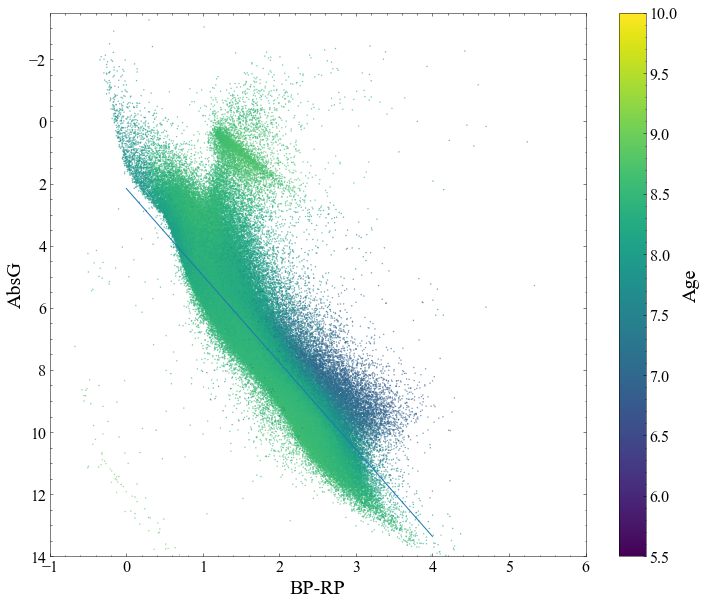

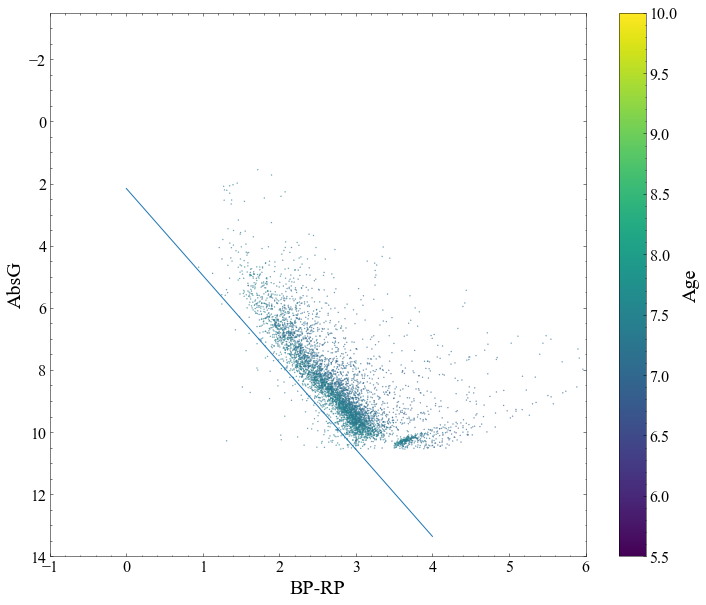

In [46]:
tOri_alt = hr(ORI, oriTab,10.5,False, out = True, mod = model1)
# tPlane = hr(GAL, galTab,10.5,False, out = True)
# tHi = hr(HI[np.where(hiTab['PHOT_BP_MEAN_MAG']<21)[0],:,:], hiTab[np.where(hiTab['PHOT_BP_MEAN_MAG']<21)[0]], 10.5, False, out = True)
tAllSky_alt = hr(ALL, allTab, 7.5, True, out= True, mod=model1)

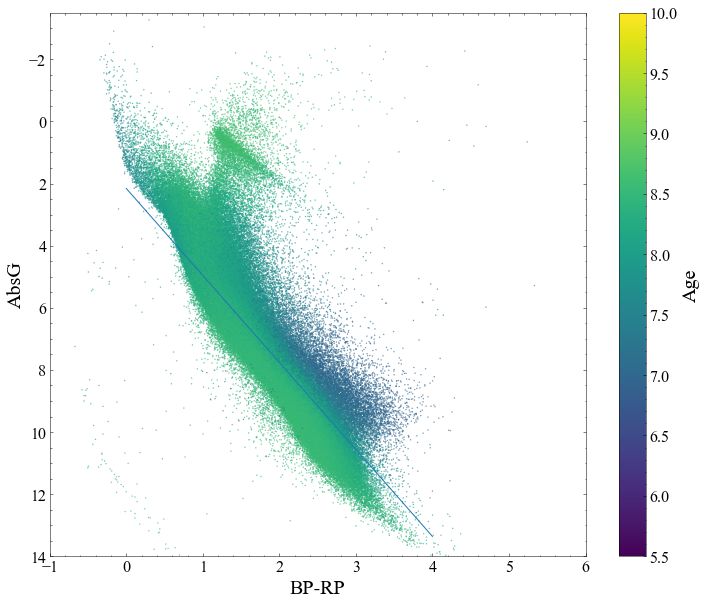

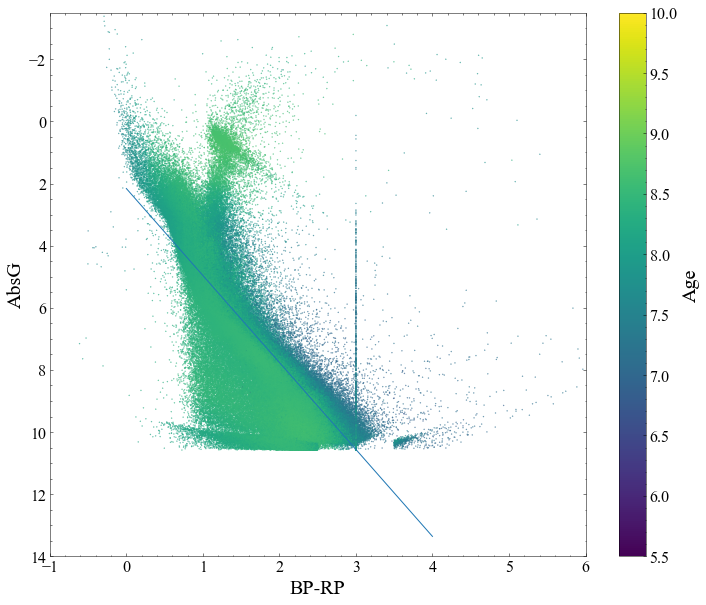

In [51]:
tOri_alt2 = hr(ORI, oriTab,10.5,False, out = True, mod = model2)
# tPlane = hr(GAL, galTab,10.5,False, out = True)
# tHi = hr(HI[np.where(hiTab['PHOT_BP_MEAN_MAG']<21)[0],:,:], hiTab[np.where(hiTab['PHOT_BP_MEAN_MAG']<21)[0]], 10.5, False, out = True)
tAllSky_alt2 = hr(ALL, allTab, 10.5, True, out= True, mod=model2)

In [20]:
from astropy.wcs import WCS
from astropy.wcs.utils import skycoord_to_pixel
from astropy.coordinates import SkyCoord

filename = 'C:\\users\\sahal\\2018TrinaryWork\\TrinaryStarSearch\\Data\\ch4_merged_clean.fits'
hdu = fits.open(filename)[0]
hdu.header['CTYPE1']='RA---TAN-SIP'
hdu.header['CTYPE2']='DEC--TAN-SIP'
wcs = WCS(hdu.header)

def coordOver(ra,dec, w = wcs):
    s =SkyCoord(ra,dec, unit = 'deg', frame = 'icrs')
    return skycoord_to_pixel(s, w, mode = 'wcs')

def plotPoints(table, age):
    fig  = plt.figure(figsize=(14, 12))
    ax = plt.subplot(projection = wcs)
    ax.grid()
       
    RIGHT = ax.coords[0]
    DECL = ax.coords[1]
    RIGHT.set_major_formatter('d.ddd')
    DECL.set_major_formatter('d.ddd')
    
    ax.set_xlabel(r'$\alpha$ J2000')
    ax.set_ylabel(r'$\delta$ J2000')

    i = np.where(table['age_predicted']<age)[0]
    age = 10**table['age_predicted'][i]/1e6    
    x,y=coordOver(table['ra'][i],table['dec'][i])
    
    A = ax.scatter(x,y, s=2, c=age, cmap='viridis')
    fig.colorbar(A, ax=ax, label = 'Age (Myr)')
        
    plt.show()

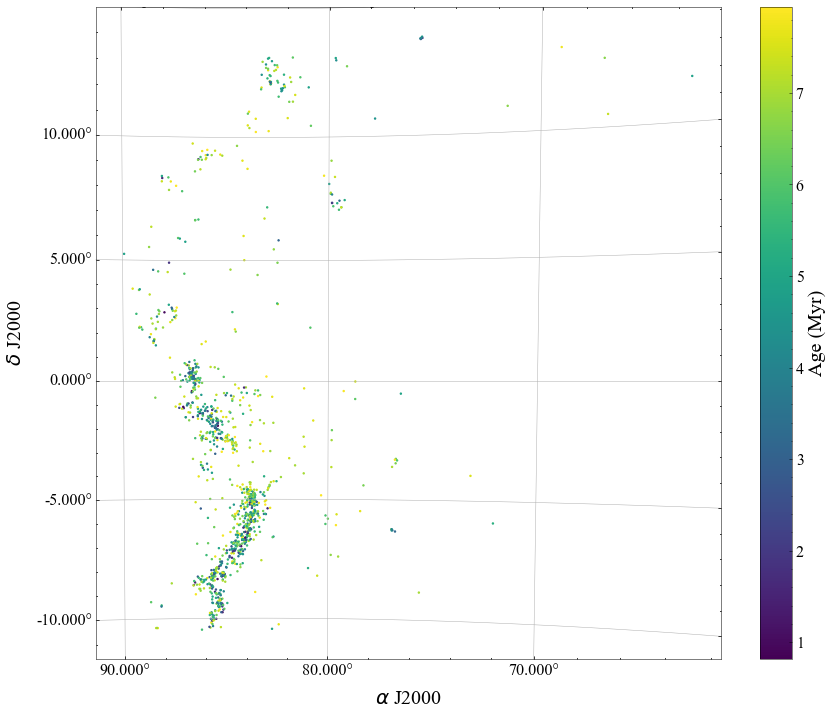

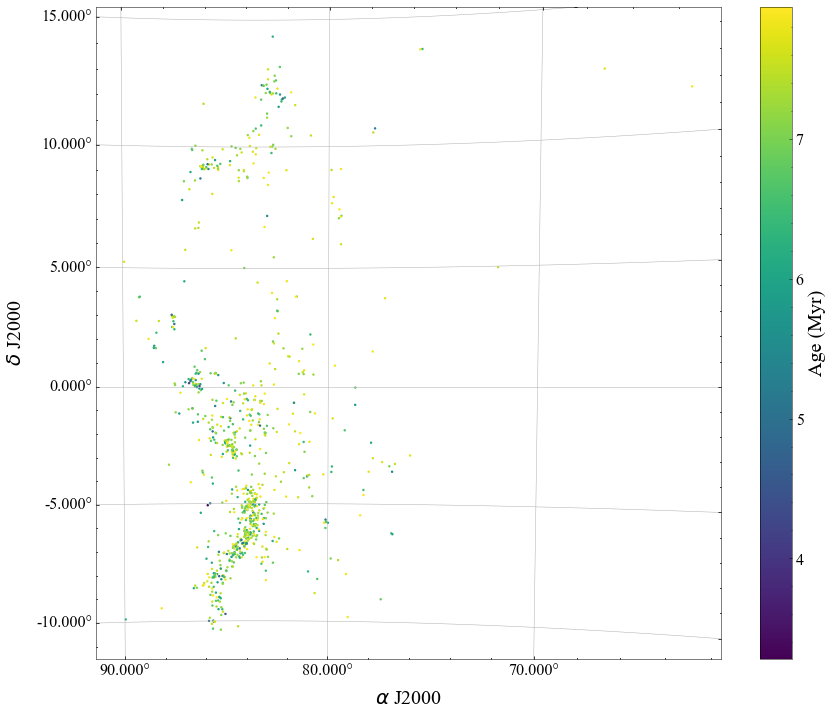

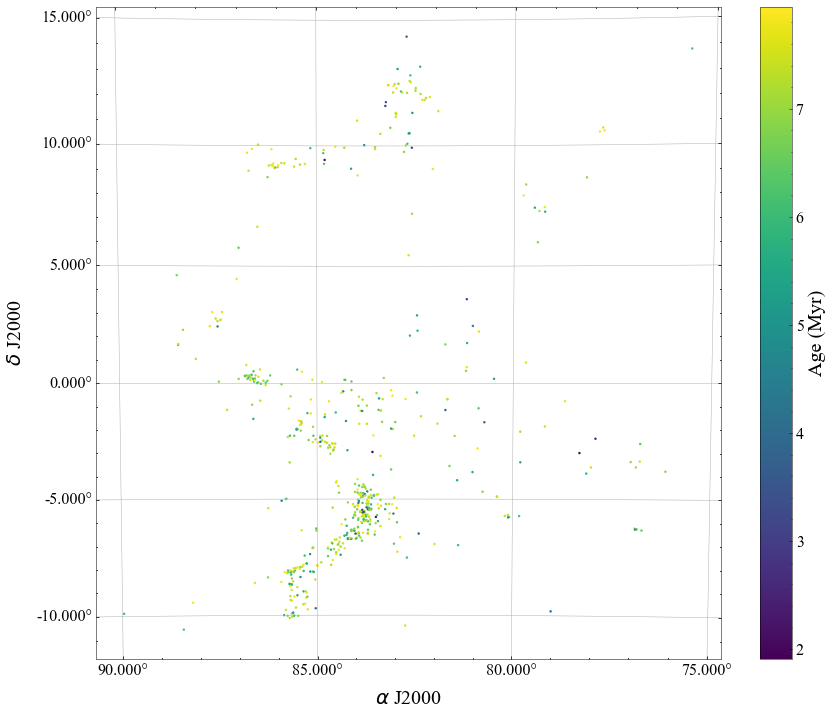

In [54]:
plotPoints(tOri, 6.9)#GO BACK TO BENCHMARK
# print(np.nanmin(tOri['age_predicted']))
plotPoints(tOri_alt, 6.9)
plotPoints(tOri_alt2, 6.9)

In [93]:
def plotSky(tab, agemax = 7.5, distance = 500):
    
    
    fig = plt.figure(figsize = (15,10))
    ax = plt.subplot(projection = 'aitoff')
    ax.grid(True)

    young = tab[np.where(tab['age_predicted']<agemax)[0]]
    
    if distance != 500:
        par = 1/distance * 10**3
        young = young[np.where(young['parallax']>par)]

    c_icrs = SkyCoord(young['ra'], young['dec'], unit = 'deg', frame = 'icrs')
    c_gal = c_icrs.galactic
    l_rad = c_gal.l.wrap_at(180*u.deg).radian
    b_rad = c_gal.b.radian

    clr = 10**young['age_predicted']/1e6
    ax.set_xticklabels([150,120,90,60,30,0,330,300,270,240,210])
    a = ax.scatter(-l_rad, b_rad, s=2,c=clr)
    fig.colorbar(a, ax = ax, label = 'Age (Myr)')

    plt.show()


In [91]:
plotSky(tAllSky)
plotSky(tAllSky_alt)
plotSky(tAllSky_alt2)

NameError: name 'tAllSky' is not defined

In [ ]:
import time

Working with really big tables requires better management of data

In [33]:
def hr_bigdata(inTens,inTab, maxAge, bad, save=False, out = True, mod = model):
    
    
    mod.eval()
    
    start = 0
    stop = start+50000
    
    dat = pd.DataFrame({'age':[], 'av':[]})
    
    ongoing = True
    t=time.time()
    while ongoing:
        sample = inTens[start:stop, :, :]
        mod.eval()
        d = mod(sample)
        dataf = pd.DataFrame(d.cpu().detach().numpy(), columns = ['age', 'av']) #['age', 'av', 'mass', 'teff', 'logg', 'feh']
        dat = pd.concat([dat, dataf])
        
        start = stop
        
        if (start + 50000 <= len(inTens)):
            stop = start + 50000
        else:
            stop = len(inTens)
            
        if start % 1000000 == 0:
            print('Number: ', start)
            print('Time: ', time.time()-t)
        if start == len(inTens):
            ongoing = False
        
    base = pd.DataFrame(inTens.flatten(1).cpu().numpy(), columns = ['g','bp','rp','j','h','k','w1','w2','parallax','radius','logl'])


    for label, content in dat.items():
        dat[label] = convunit(content, label, back=True)#Return to typical form

    bprp = convunit(base['bp'], 'bp', back = True)-convunit(base['rp'], 'rp', back = True)
    G = absG(convunit(base['g'], 'g', back = True), convunit(base['parallax'], 'parallax', back = True))

    fig, ax = plt.subplots(1,1,figsize = (12,10))
    
    #Check for good quality data!
    if bad == False:
        d = bData(inTab)
    else:
        d = np.arange(len(inTab))

    age = np.array(dat['age'])
    ii = np.where(age<maxAge)[0]
    ii = np.intersect1d(d,ii)

    NORM = colors.Normalize(vmin = 5.5, vmax = 10)

    ax.set_ylim(14,-3.5)
    ax.set_xlim(-1,6)
    ax.set_xlabel('BP-RP')
    ax.set_ylabel('AbsG')

    a = ax.scatter(bprp[ii], G[ii], s = .1, c = age[ii],alpha = 1, norm = NORM, cmap = 'viridis')
    fig.colorbar(a, ax = ax, label = 'Age')
    ax.plot(np.linspace(0,4),2.8 * np.linspace(0,4)+2.16)
    plt.show()
    
    K = Table(inTab)
    K['age_predicted']=age
    if save == True:
        K[ii].write('drive/My Drive/YSO_ML/CHECKOUT_0.fits',overwrite=True)
    if out == True:
        return K[ii]

Number:  1000000
Time:  20.85144352912903
Number:  2000000
Time:  43.138782024383545
Number:  3000000
Time:  63.46365833282471
Number:  4000000
Time:  87.83719182014465
Number:  5000000
Time:  109.84228801727295
Number:  6000000
Time:  133.99580931663513
Number:  7000000
Time:  154.24354767799377
Number:  8000000
Time:  175.57231616973877
Number:  9000000
Time:  198.42853450775146
Number:  10000000
Time:  219.33224606513977
Number:  11000000
Time:  240.8404130935669


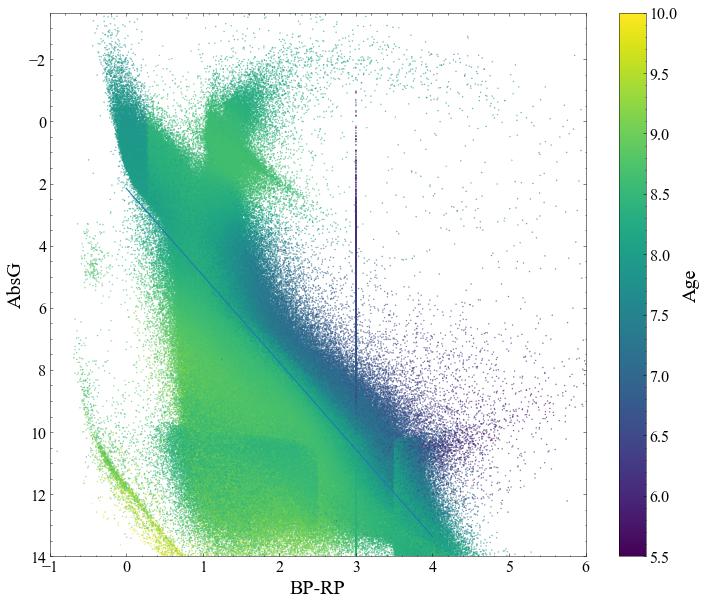

In [31]:
tBig = hr_bigdata(BIG, bigTab, 11, True, out= True, mod=model)

Number:  1000000
Time:  20.94867730140686
Number:  2000000
Time:  40.995079040527344
Number:  3000000
Time:  62.401845932006836
Number:  4000000
Time:  86.2486252784729
Number:  5000000
Time:  109.70435643196106
Number:  6000000
Time:  133.21689653396606
Number:  7000000
Time:  157.04932188987732
Number:  8000000
Time:  180.50400733947754
Number:  9000000
Time:  204.00003576278687
Number:  10000000
Time:  228.5841987133026
Number:  11000000
Time:  253.05641746520996


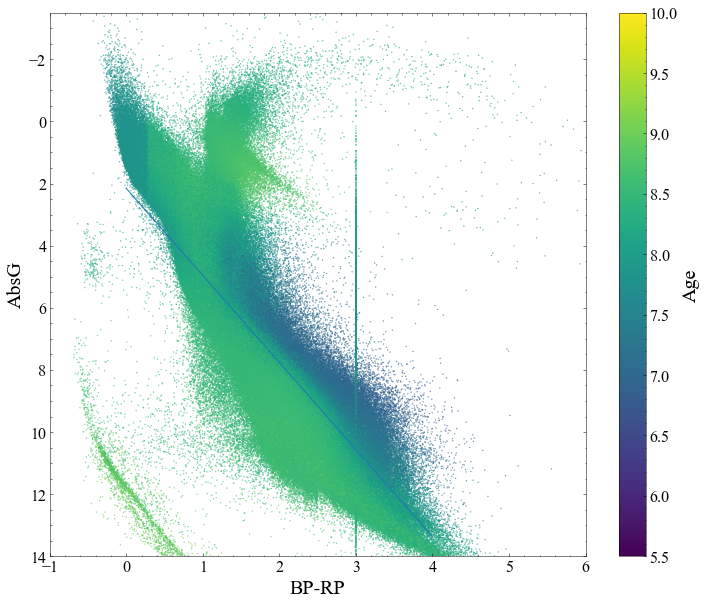

In [62]:
tBig1 = hr_bigdata(BIG, bigTab, 11, False, out= True, mod=model1) #THis is the preferred model right now!

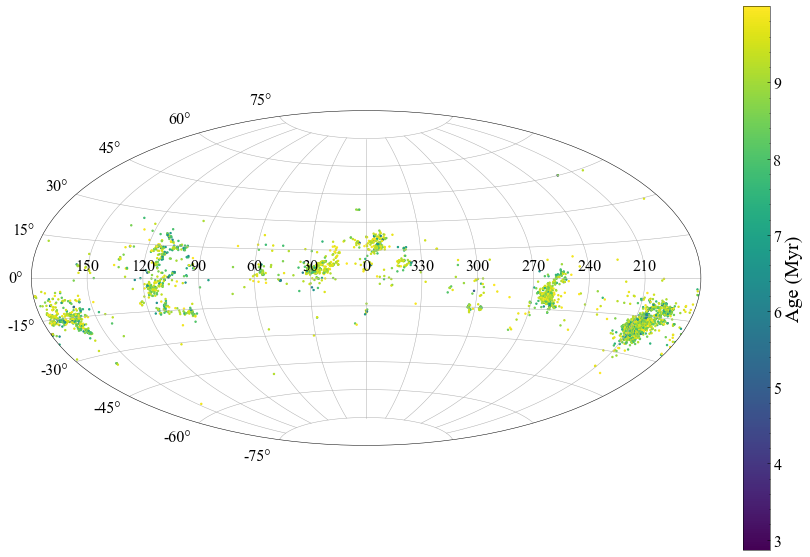

In [94]:
plotSky(tBig1, agemax=7, distance = 500) #This used model 1 or 2

In [65]:
# plotSky(tBig, agemax=7.2, distance = 100) #This used model 1 or 2

![](image.png)

In [67]:
tBig1[np.where(tBig1['age_predicted']<7.5)[0]].write('big1.fits', overwrite=True)

In [76]:
def icrsToGal(tab):
    c = SkyCoord(tab['ra'],tab['dec'],unit='deg',frame='icrs')
    c_gal = c.galactic
    l = c_gal.l
    b = c_gal.b
    tab['l']=l.deg
    tab['b']=b.deg

In [86]:
young = tBig1[np.where(tBig1['age_predicted']<7)[0]]
icrsToGal(young)

In [87]:
k = len(np.where((young['b']<-45)|(young['b']>45))[0])
print(k/len(young))

0.0009723842862699338
